In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
from scipy.optimize import curve_fit

In [2]:
Data = xr.open_dataset('.\p100_c1_monmean.nc')
Data

<xarray.Dataset>
Dimensions:    (time: 360, bnds: 2, lon: 128, lat: 64, lev: 11)
Coordinates:
  * time       (time) object 1881-01-15 12:00:00 ... 1910-12-15 12:00:00
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat        (lat) float64 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
  * lev        (lev) float64 1e+03 900.0 850.0 800.0 ... 400.0 300.0 200.0 100.0
Dimensions without coordinates: bnds
Data variables: (12/21)
    time_bnds  (time, bnds) object ...
    ta         (time, lev, lat, lon) float32 ...
    ua         (time, lev, lat, lon) float32 ...
    va         (time, lev, lat, lon) float32 ...
    ts         (time, lat, lon) float32 ...
    snd        (time, lat, lon) float32 ...
    ...         ...
    rls        (time, lat, lon) float32 ...
    rst        (time, lat, lon) float32 ...
    rlut       (time, lat, lon) float32 ...
    tauu       (time, lat, lon) float32 ...
    tauv       (time, lat, lon) float32 ...
    evap       (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    title:        PUMA/PLASIM DATA
    history:      Wed Jun 08 15:20:08 2022: cdo monmean p100_c1.nc p100_c1_mo...
    frequency:    mon
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [18]:
GMST = Data.ts.mean('lat').mean('lon')
yearlyGMST = np.zeros(30)
a = 0
m = 0
j = 0
for i in range(360):
    if (a!=12):
        m = m+GMST[i]
        a = a + 1
        if (a == 12):
            yearlyGMST[j] = m/12
            j = j + 1
            m = 0
            a = 0
years = [i for i in range(30)]

In [23]:
def R(t,q1,d1,q2,d2):
    return q1*np.exp(-t/d1)+q2*np.exp(-t/d2)

def C(tau):
    co2 = [285 for i in range(30)]
    co2[1] = 185
    return co2[tau]

def F(tau):
    F2x=3.74
    Fext=340
    return (F2x/np.log(2))*np.log(C(tau)/C(0))+Fext

def T(years,q1,d1,q2,d2):
    T1=np.zeros(30)
    for t in range(len(years)):
        for i in range(t):
            T1[t] = T1[t]+R(t-i,q1,d1,q2,d2)*F(i)
    return T1

def temp(time,q1,d1,q2,d2):
    return T(time,q1,d1,q2,d2)+yearlyGMST[0]

In [32]:
popt1, pcov1 = curve_fit(temp, years, yearlyGMST)

In [33]:
popt1

array([ 0.00752461,  2.48820392, -0.05368377,  0.64072017])

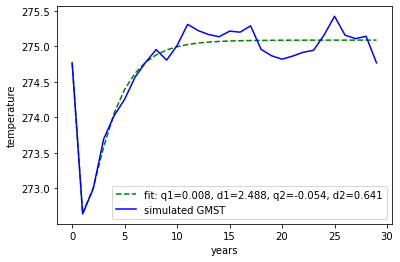

In [35]:
plt.plot(years, temp(years, *popt1), 'g--', label='fit: q1=%5.3f, d1=%5.3f, q2=%5.3f, d2=%5.3f' % tuple(popt1))
plt.plot(years, yearlyGMST, 'b-', label='simulated GMST')
plt.xlabel('years')
plt.ylabel('temperature')
plt.legend()
plt.show()